In [13]:
!pip install --upgrade wandb

  Using cached wandb-0.16.2-py3-none-any.whl.metadata (9.8 kB)
Using cached wandb-0.16.2-py3-none-any.whl (2.2 MB)
  Attempting uninstall: wandb
    Found existing installation: wandb 0.16.0
    Uninstalling wandb-0.16.0:
      Successfully uninstalled wandb-0.16.0

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [14]:
import os

# 원하는 노트북 이름을 설정하세요.
notebook_name = "WB.ipynb"

# 환경 변수 설정
os.environ['WANDB_NOTEBOOK_NAME'] = notebook_name


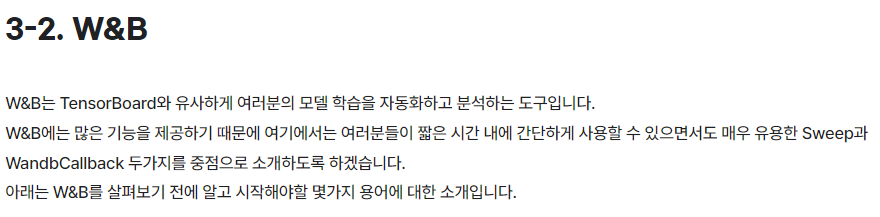

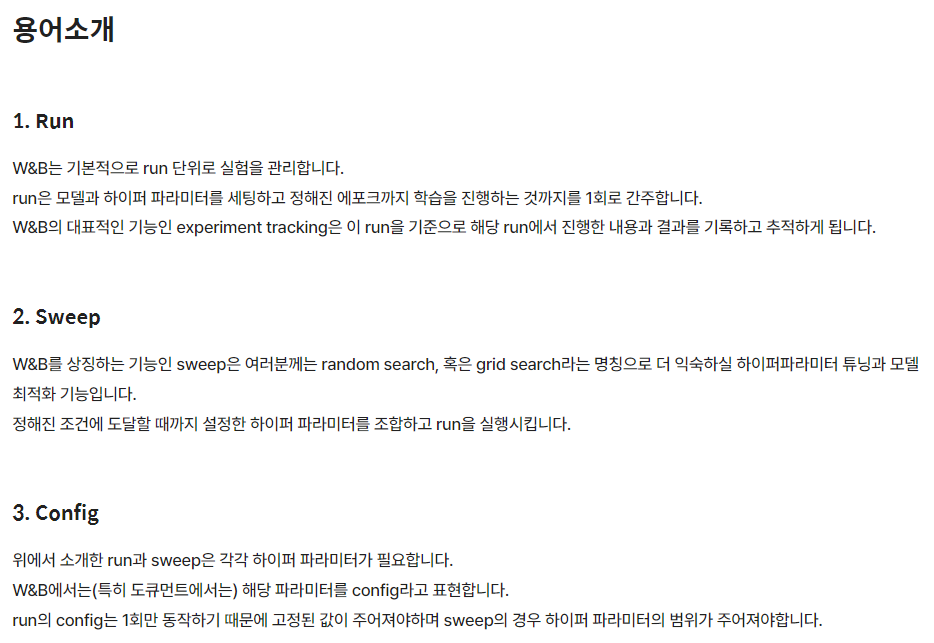

In [15]:
!pip install wandb==0.16.0

  Using cached wandb-0.16.0-py3-none-any.whl.metadata (9.8 kB)
Using cached wandb-0.16.0-py3-none-any.whl (2.1 MB)
  Attempting uninstall: wandb
    Found existing installation: wandb 0.16.2
    Uninstalling wandb-0.16.2:
      Successfully uninstalled wandb-0.16.2

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [16]:
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder
from PIL import Image 
import glob
import os

In [17]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-hsrmz9xg
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-hsrmz9xg
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


,file_name,image,label,segmentation_mask,species
0,Sphynx_158.jpg,,33 (Sphynx),,0 (Cat)
1,english_cocker_spaniel_135.jpg,,12 (english_cocker_spaniel),,1 (Dog)
2,British_Shorthair_181.jpg,,9 (British_Shorthair),,0 (Cat)
3,Siamese_161.jpg,,32 (Siamese),,0 (Cat)
4,Sphynx_178.jpg,,33 (Sphynx),,0 (Cat)
5,american_pit_bull_terrier_139.jpg,,2 (american_pit_bull_terrier),,1 (Dog)
6,newfoundland_122.jpg,,22 (newfoundland),,1 (Dog)
7,newfoundland_108.jpg,,22 (newfoundland),,1 (Dog)
8,yorkshire_terrier_131.jpg,,36 (yorkshire_terrier),,1 (Dog)
9,Bengal_149.jpg,,5 (Bengal),,0 (Cat)

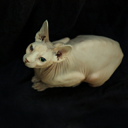
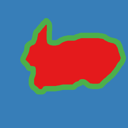
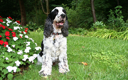
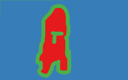
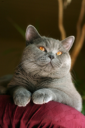
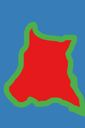
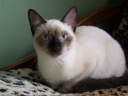
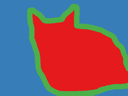
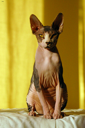
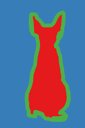
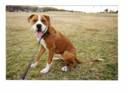
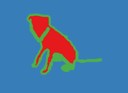
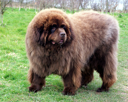
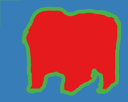
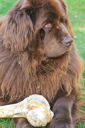
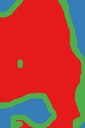
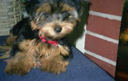
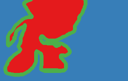
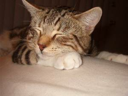
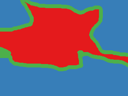

In [18]:
(train, test), info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, split=['train', 'test'])
df = tfds.as_dataframe(train.take(10), info)
df

In [19]:
# 시각화를 위해 일부 데이터를 sample로 만들겠습니다

X_samples = df['image']
y_samples = df['segmentation_mask']

In [20]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_images = train.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = test.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

In [21]:
wandb.login(key = "93419eb8a19caec1b5a855c81c59767847da9775")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [22]:
sweep_config = {
    "name": "sweep_test_cv",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

In [27]:
def train():
    default_config = {
        "input" : (128,128,3),
        "filter" : 16,
        "kernel" : (3,3),
        "activation" : "relu",
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32,
        "project" : 'test_project'
    }

    wandb.init(config = default_config)
    config = wandb.config

    # Model

    model=keras.models.Sequential()
    model.add(keras.layers.Conv2D(config.filter, config.kernel, activation=config.activation, input_shape=config.input, padding = 'same'))
    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Conv2DTranspose(16, (3,3), 2, padding = 'same'))


    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.

    if config.optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = config.learning_rate)
    
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=config.metrics)

    # WandbCallback 함수는 후술합니다.
    model.fit(train_batches,
              epochs=config.epoch,
              steps_per_epoch=STEPS_PER_EPOCH,
              validation_steps=VALIDATION_STEPS,
              validation_data=test_batches,
              callbacks = [WandbCallback(validation_data = (X_samples, y_samples),
                                         predictions = 10,
                                         input_type = "auto",
                                         output_type = "segmentation_mask",
                                         save_model=True, save_format="tf")])

    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [28]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = None,
                       project = 'test_project')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)

Create sweep with ID: k805pgzg
Sweep URL: https://wandb.ai/dudnjsckrgo/test_project/sweeps/k805pgzg


wandb: Agent Starting Run: p8qgztad with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.011510603589659585


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Run p8qgztad errored: AttributeError("property 'model' of 'WandbCallback' object has no setter")
wandb: ERROR Run p8qgztad errored: AttributeError("property 'model' of 'WandbCallback' object has no setter")
wandb: Agent Starting Run: ad08d0is with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.012697738441238397


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Run ad08d0is errored: AttributeError("property 'model' of 'WandbCallback' object has no setter")
wandb: ERROR Run ad08d0is errored: AttributeError("property 'model' of 'WandbCallback' object has no setter")
wandb: Agent Starting Run: btuibogy with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.01906041252875631


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Run btuibogy errored: AttributeError("property 'model' of 'WandbCallback' object has no setter")
wandb: ERROR Run btuibogy errored: AttributeError("property 'model' of 'WandbCallback' object has no setter")
Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: ERROR Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: To disable this check set WANDB_AGENT_DISABLE_FLAPPING=true
